In [1]:
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")
spark

Spark and Delta Lake are ready!


In [3]:
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

# 1.managed vs unmanaged

In [28]:
df.write.format("delta").mode("overwrite").saveAsTable("order_managed")
spark.sql("CREATE TABLE if not exists  orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'").show()

++
||
++
++



In [21]:
spark.sql("SELECT * FROM order_managed").show()
spark.sql("SELECT * FROM orders_unmanaged").show()
spark.sql("describe extended order_managed").show()
spark.sql("describe extended orders_unmanaged").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+---

#  2. CRUD Operations

In [26]:
spark.sql("select*from order_managed").show()



+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [30]:
spark.sql("""update order_managed set amount=amount+20 where category='Clothing'""").show()
spark.sql("select*from order_managed").show()

+-----------------+
|num_affected_rows|
+-----------------+
|                2|
+-----------------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [44]:
spark.sql("""delete from order_managed where quantity<2""").show()
spark.sql("select*from order_managed").show()
source=spark.read.table("order_managed")


+-----------------+
|num_affected_rows|
+-----------------+
|                0|
+-----------------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



IllegalArgumentException: requirement failed: The number of columns doesn't match.
Old column names (5): order_id, customer_name, category, quantity, amount
New column names (0): 

In [62]:
from delta.tables import DeltaTable
deltatable=DeltaTable.forPath(spark,"/tmp/orders_delta")
from pyspark.sql import Row
new_data = [
  Row(order_id=2, customer_name='Sara', category='Clothing', quantity=2, amount=100),
  Row(order_id=5, customer_name='Liam', category='Electronics', quantity=1, amount=200)
]
updates_df = spark.createDataFrame(new_data)
updates_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|         Sara|   Clothing|       2|   100|
|       5|         Liam|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



In [64]:
deltatable.alias("target").merge(updates_df.alias("updates"),"target.order_id=updates.order_id").whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

In [65]:
deltatable.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       2|   100|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



# 3. History & Time Travel

In [67]:
spark.sql("describe history order_managed").show()
spark.sql("select*from order_managed version as of 0").show()

+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      7|2025-08-14 06:17:...|  NULL|    NULL|              DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|          6|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      6|2025-08-14 06:16:...|  NULL|    NULL|              UPDATE|{predicate -> ["(...|NULL|    NULL|     NULL|          5|  Serializable|        false|{numRemoved

# 4. Incremental Load Pattern

In [71]:
batch_data = [
  (5, "Liam", "Electronics", 1, 200),
  (6, "Emma", "Clothing", 2, 120)
]
batch_df = spark.createDataFrame(batch_data, columns)
batch_df.show()
batch_df.write.format("delta").mode("append").save("/tmp/orders_delta")
check_df=spark.read.format("delta").load("/tmp/orders_delta")
check_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       5|         Liam|Electronics|       1|   200|
|       6|         Emma|   Clothing|       2|   120|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       2|   100|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
|       5|         Liam|Electronics|       1|   200|
|       5|         Liam|Electronics|       1|   200|
|       6|         Emma|   Clothing|       2|   120|
|       6|         Emma|   Clothing|       2|   120|
+--------+-------------+-----------+--------+

# simple streaming read

In [88]:
delta_stream=(spark.readStream.format("delta").load("/tmp/orders_delta"))
mem_q = (
  delta_stream.writeStream
              .format("memory")
              .queryName("orders_em")
              .outputMode("append")
              .trigger(processingTime="5 seconds")
              .start()
)

mem_q.awaitTermination(60)
mem_q.stop()



In [89]:
spark.sql("SELECT * FROM orders_em").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       2|   100|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
|       3|        kumar|Electronics|       1|   200|
|       5|         Liam|Electronics|       1|   200|
|       5|         Liam|Electronics|       1|   200|
|       6|         Emma|   Clothing|       2|   120|
|       6|         Emma|   Clothing|       2|   120|
+--------+-------------+-----------+--------+------+



#  6. Visualization

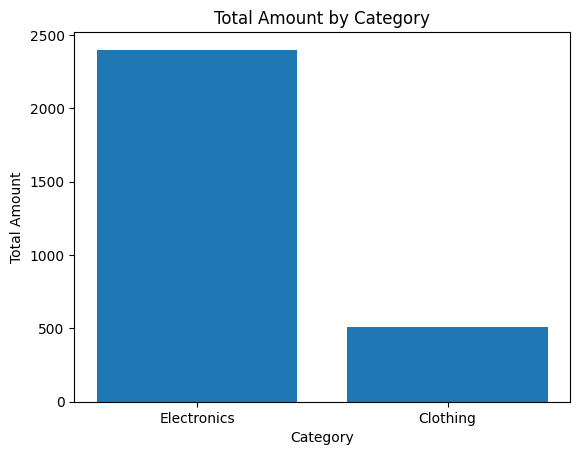

In [96]:
dp=deltatable.toDF()
DP=dp.toPandas()
DP['total_amount']=DP['quantity']*DP['amount']
import matplotlib.pyplot as plt
plt.bar(DP['category'],DP['total_amount'])
plt.xlabel('Category')
plt.ylabel('Total Amount')
plt.title('Total Amount by Category')
plt.show()
